# Cleaning Modes With Rational Filters

In [52]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [53]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy

## Data

Download data

In [54]:
home_dir = "./MDC_waveforms/"

In [55]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [56]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

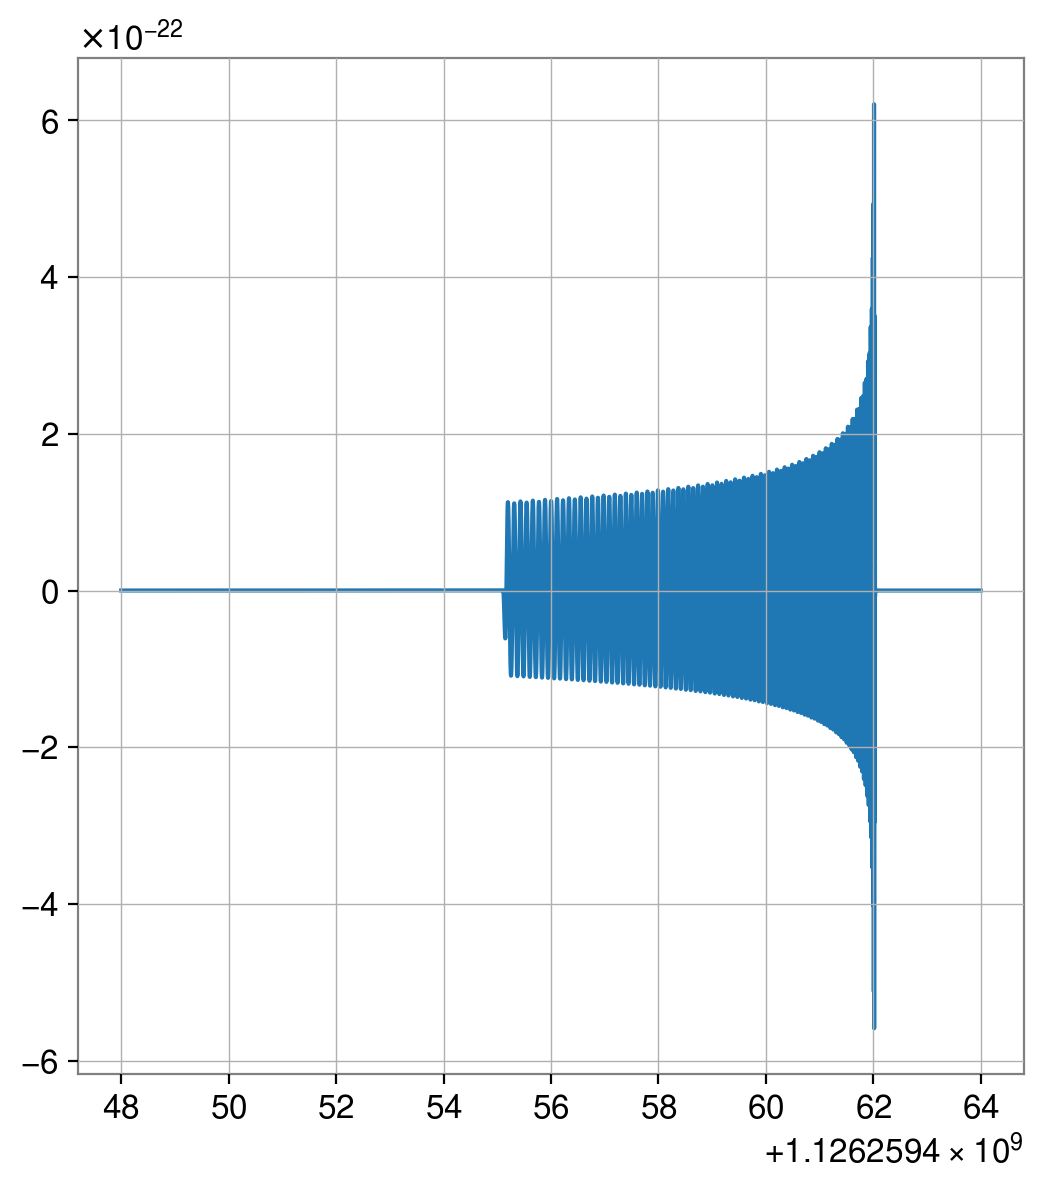

In [57]:
pl.plot(H_data)
# pl.plot(L_data)

In [58]:
H_waveform = qnm_filter.Data(H_data.value, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value, index = L_data.times.value)

In [59]:
peak_time = H_data.times.value[np.argmax(H_waveform)]
SSB_peak_time = peak_time - 0.014685396838313368

## Filter

In [358]:
input = dict(model_list = [(2, 2, 0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+1e-3, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 4096,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [359]:
fit.original_data['H1'] = H_waveform

In [360]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [361]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1e-22**2
fit.acfs['H1'] = qnm_filter.Data(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

In [362]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [363]:
fit.compute_SNR(0, template, 'H1', optimal=True)

16.940444486293632

In [364]:
delta_mass = 1.0
delta_chi = 0.03
massspace = np.arange(34, 150, delta_mass)
chispace = np.arange(0.0, 0.99, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [365]:
flatten_array = [(i, j) for i in massspace for j in chispace]
saved_log_evidence = []

In [366]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, '$\\chi_f$')

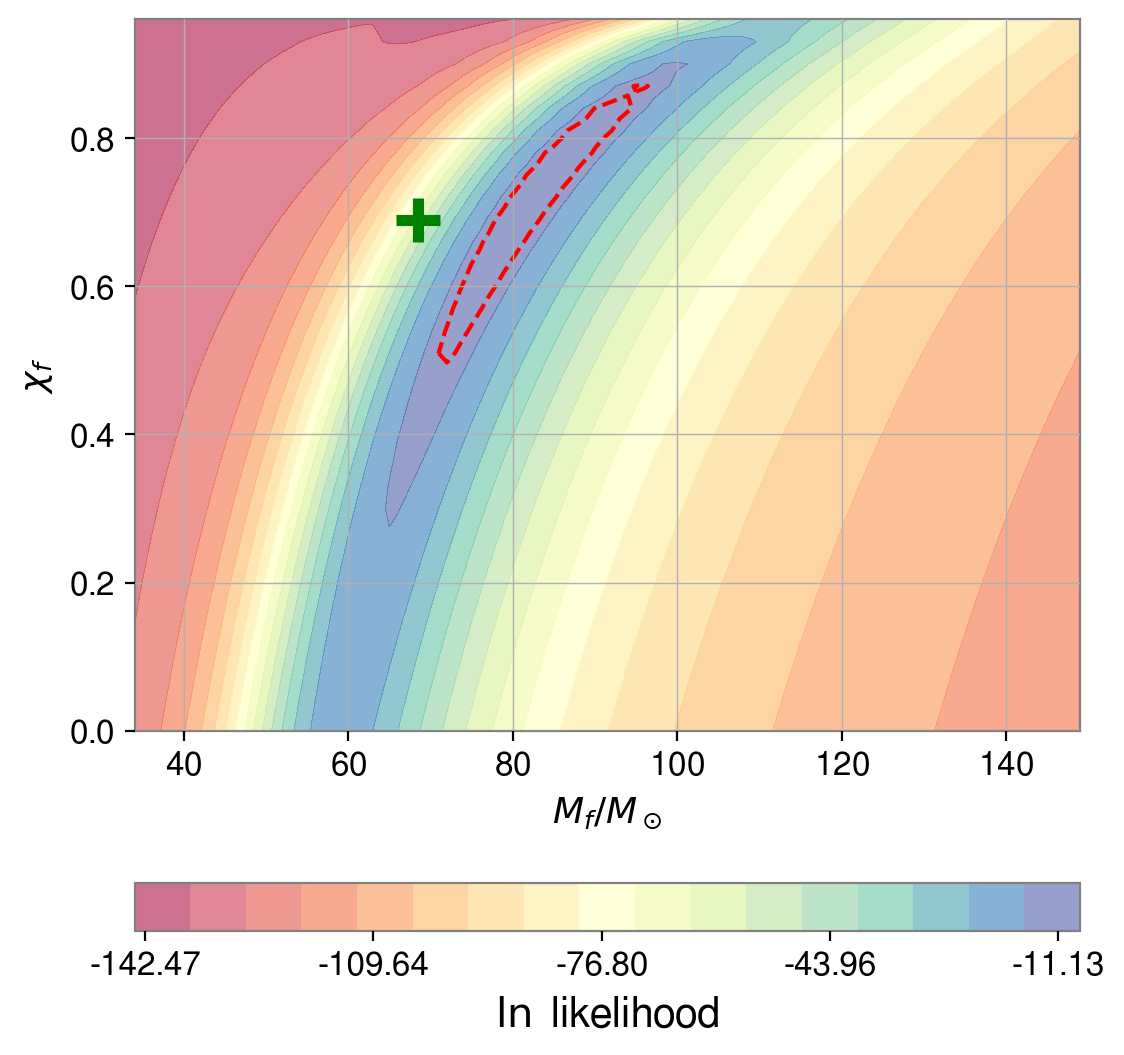

In [367]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

In [368]:
evidence #120

-7.929670235202998

In [378]:
evidence = logsumexp(likelihood_data)
normalized_mass = np.exp(logsumexp(likelihood_data, axis=0) - evidence)
normalized_chi = np.exp(logsumexp(likelihood_data, axis=1) - evidence)

renormalized_mass = normalized_mass/np.sum(normalized_mass * delta_mass)
renormalized_chi = normalized_chi/np.sum(normalized_chi * delta_chi)

In [391]:
np.sum(normalized_chi * delta_chi)

0.029999999999999995

In [392]:
delta_chi

0.03

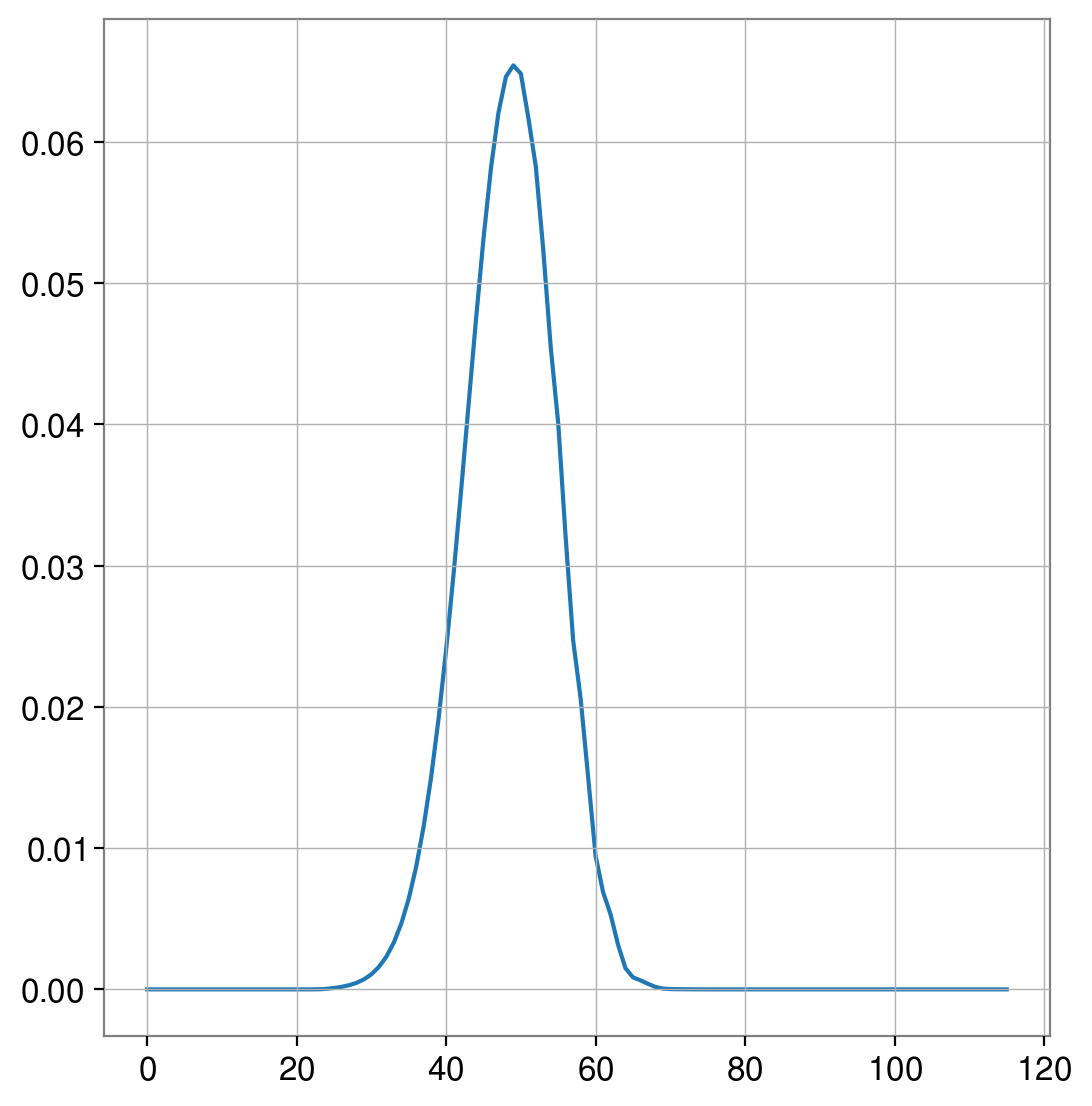

In [389]:
pl.plot(normalized_mass*delta_mass)

In [369]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [370]:
projected_chi*chispace

array([0.00000000e+00, 6.86276516e-05, 1.87063610e-04,
       3.84436283e-04, 7.05985541e-04, 1.22186399e-03,
       2.04074337e-03, 3.33083854e-03, 5.35234963e-03,
       8.50739946e-03, 1.34165827e-02, 2.10355498e-02,
       3.28308242e-02, 5.10410643e-02, 7.90567527e-02,
       1.21953383e-01, 1.87199682e-01, 2.85509419e-01,
       4.31665831e-01, 6.44838753e-01, 9.47316690e-01,
       1.35958988e+00, 1.88850986e+00, 2.50492522e+00,
       3.11117152e+00, 3.51397580e+00, 3.45033028e+00,
       2.74041541e+00, 1.55956376e+00, 5.11190486e-01,
       6.26113220e-02, 1.06291416e-03, 1.32272769e-07])

In [371]:
projected_chi[1]*chispace[1]

6.862765162088422e-05

In [372]:
from scipy.special import logsumexp
lg_evidence = logsumexp(likelihood_data)
mass_likelihood = np.exp(logsumexp(likelihood_data, axis=0) - lg_evidence)
mass_likelihood /= np.sum(mass_likelihood * delta_mass)

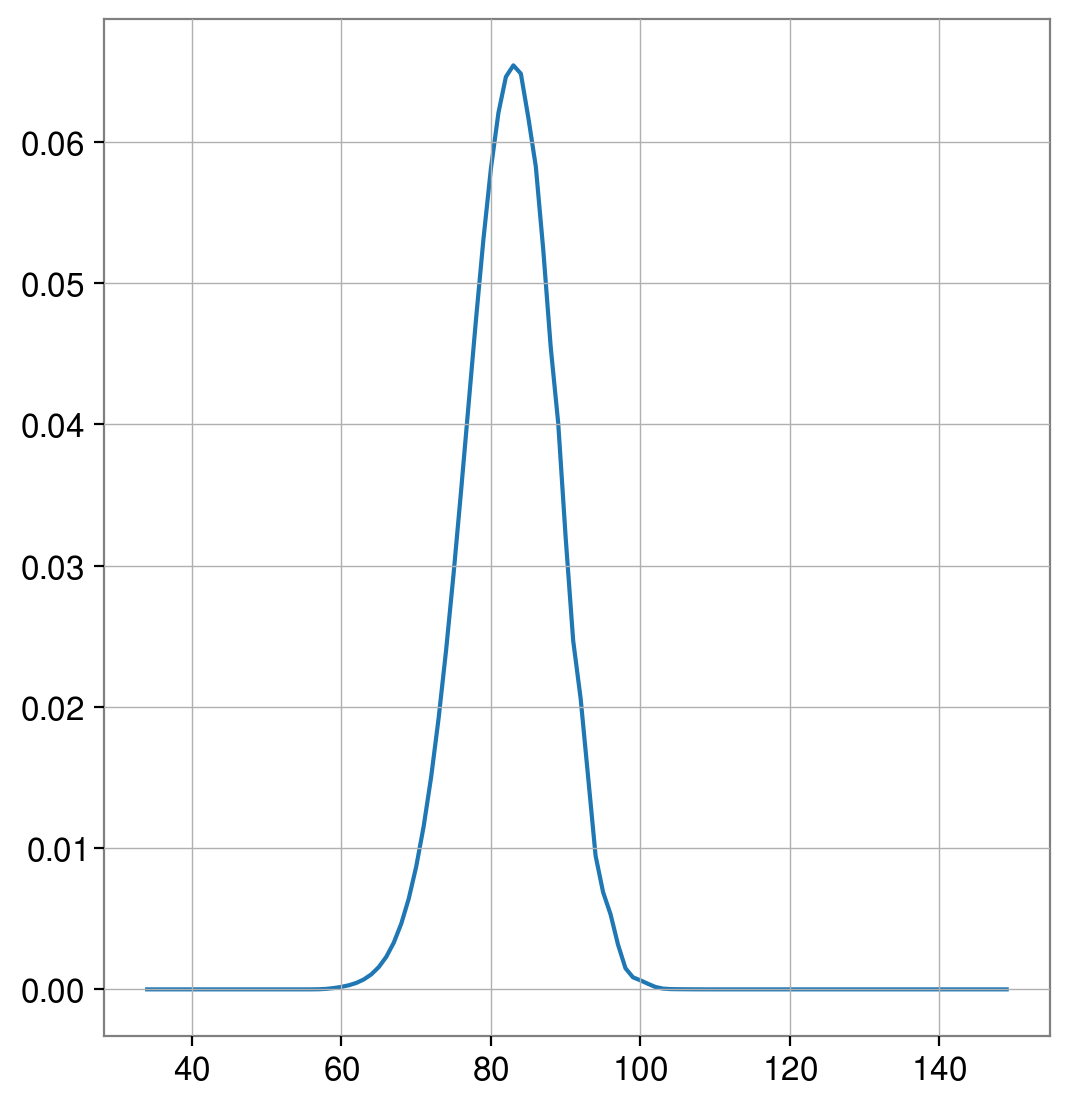

In [373]:
pl.plot(massspace, projected_mass)

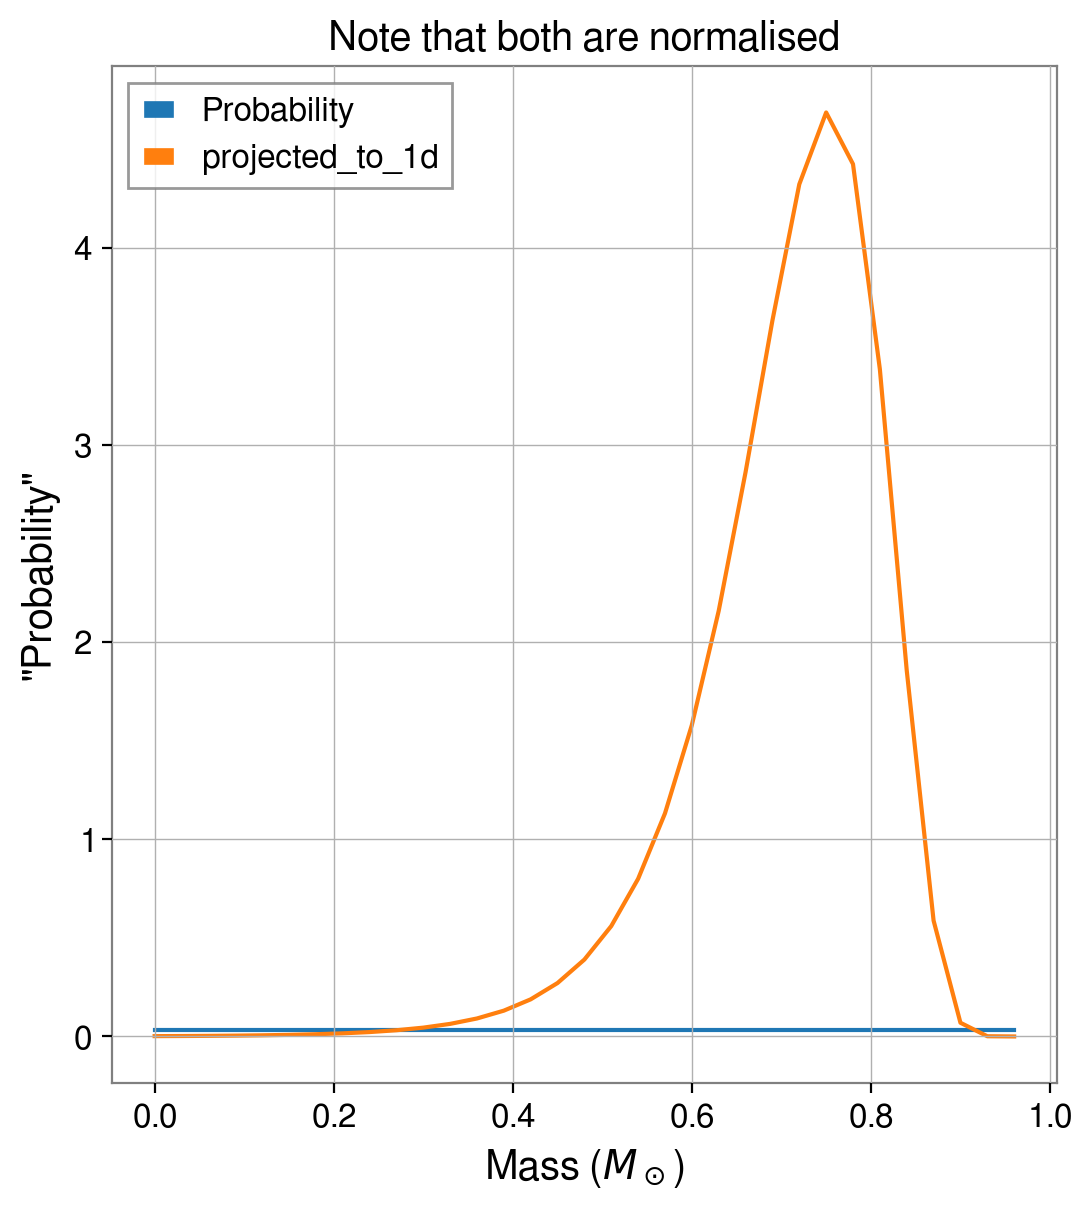

In [374]:
pl.plot(chispace, chi_prob, label = "Probability")
pl.plot(chispace, projected_chi, label = "projected_to_1d")
pl.xlabel(r'Mass ($M_\odot$)')
pl.ylabel('"Probability"')
pl.title("Note that both are normalised")
pl.legend()

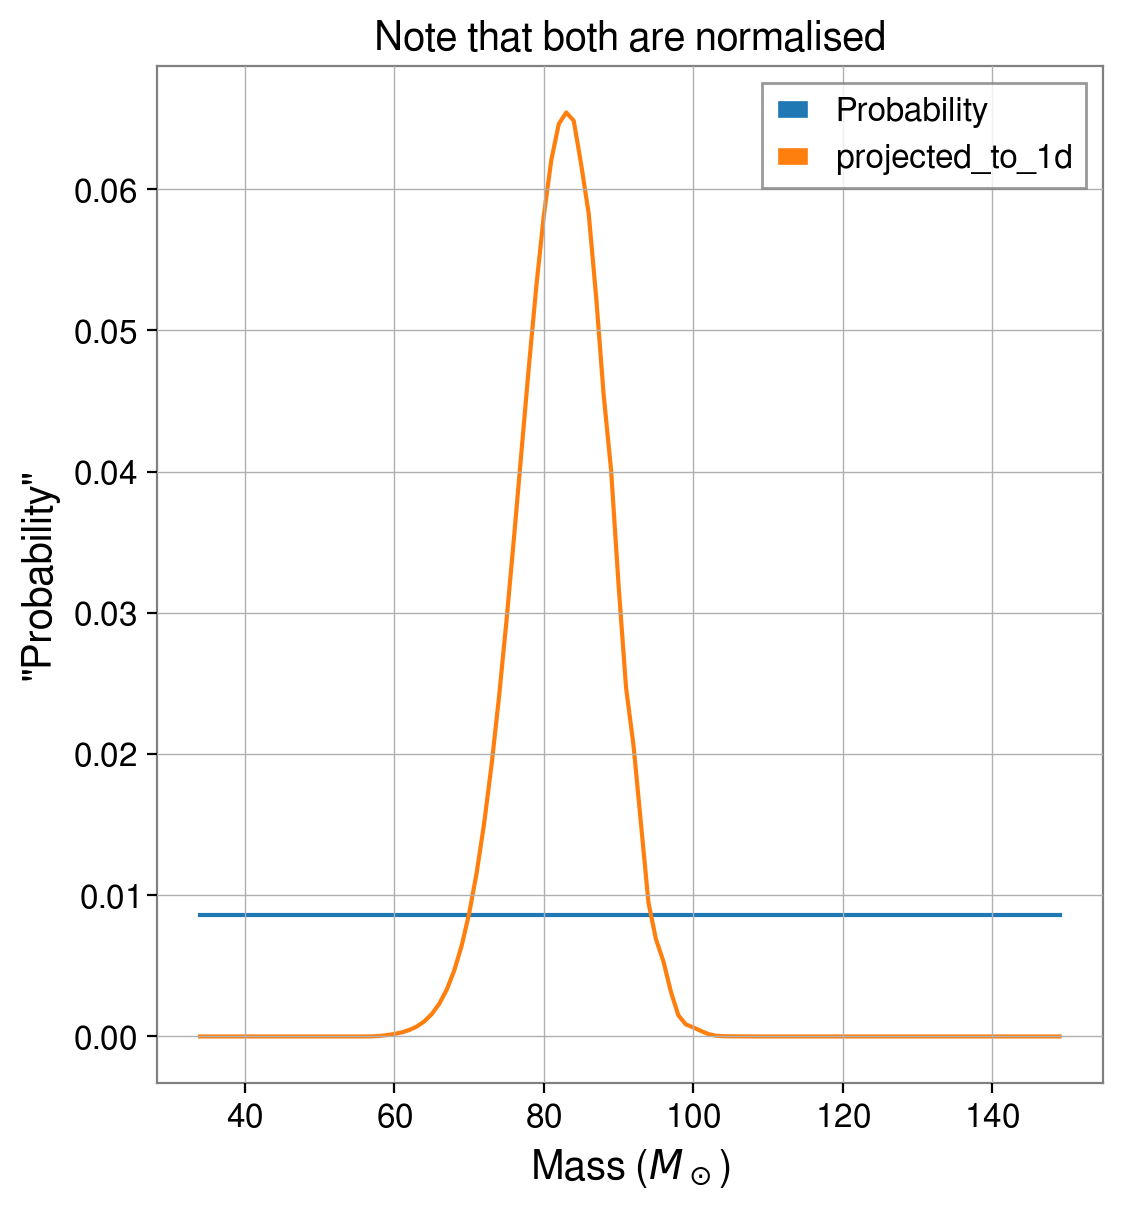

In [375]:
pl.plot(massspace, mass_prob, label = "Probability")
pl.plot(massspace, projected_mass, label = "projected_to_1d")
pl.xlabel(r'Mass ($M_\odot$)')
pl.ylabel('"Probability"')
pl.title("Note that both are normalised")
pl.legend()

In [69]:
# Probability = e**likelihood = e**(e**ln likelihood)
# Normalise probability 
# Average = probability*mass / chi
# Distance = epsilon definition from paper
# Expand M and chi region - before running on cluster

In [70]:
220, 221, 222, 210, 440, 330

(220, 221, 222, 210, 440, 330)

In [71]:
import qnm
qnm.modes_cache(s=-2, l=2, m=2, n=0)(a=0.71)[0]

(0.5371215967617101-0.08040291793305679j)

In [72]:
qnm.modes_cache(s=-2, l=2, m=1, n=0)(a=0.71)[0]

(0.4573148056129102-0.08176615773254976j)